In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import datetime

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [1]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [9]:
# figure out how sqlite is set up to create df
sample = session.query(Measurement).first()
sample.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x119dcda20>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [10]:
#same as above
sample2 = session.query(Station).first()
sample2.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11a5544e0>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [11]:
#find what the dates are for the latest 12 mo
#also use this [out] to answer "# Calculate the date 1 year ago from the last data point in the database"
lastdate = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(1).all()
lastdate

[('2017-08-23')]

In [12]:
#query for 12mo of precipitation data starting from 2016-8-23 ~ 2017-08-23
precipitation = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).all()

#df formatting
precipitation_df = pd.DataFrame(precipitation, columns = ['date', 'precipitation'])
precipitation_df = precipitation_df.sort_values(by = 'date')
precipitation_df.set_index('date', inplace = True)

#look at dataframe
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


Text(0.5, 1.0, 'Honolulu')

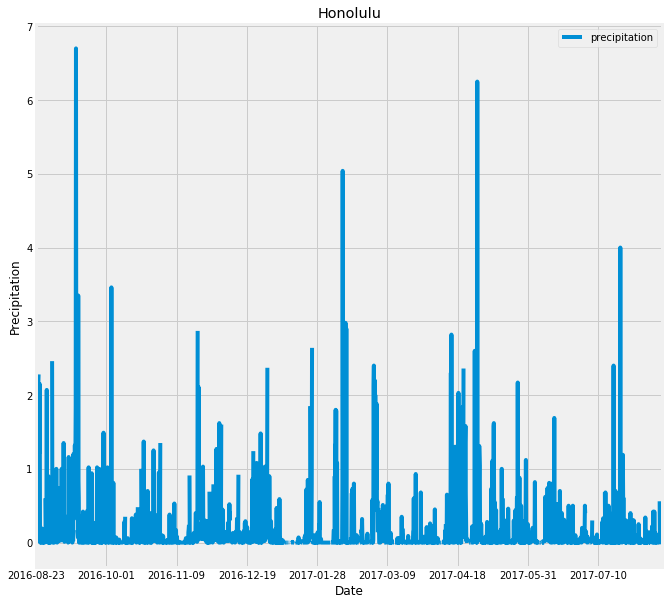

In [15]:
#create chart
fig, ax = plt.subplots(figsize = (10, 10))
precipitation_df.plot(ax = ax)

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation')
ax.set_title("Honolulu")

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
#import distinct (based on reccos from sqlalchemy website)
from sqlalchemy import distinct
session.query(func.count(distinct(Measurement.station))).limit(1).all()

[(9)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = (session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station) \
        .order_by(func.count(Measurement.station).desc()).all())
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
hightemp=(session.query(Measurement.tobs).filter(Measurement.station == "USC00519281")  
            .order_by(Measurement.tobs.desc()).first())
lowtemp=(session.query(Measurement.tobs).filter(Measurement.station == "USC00519281") 
            .order_by(Measurement.tobs.asc()).first())
avgtemp=(session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281"))

print(f"Highest = {hightemp[0]}")
print(f"Lowest = {lowtemp[0]}")
print(f"Avg = {avgtemp[0]}")

Highest = 85.0
Lowest = 54.0
Avg = (71.66378066378067,)


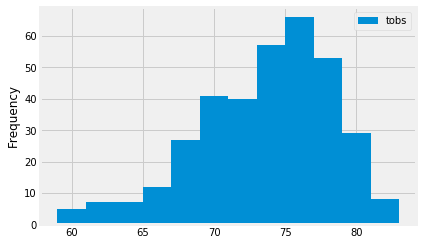

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#USC00519281

oneyear = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.tobs).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

#df formatting
oneyear_df = pd.DataFrame(oneyear, columns = ['date', 'tobs'])
oneyear_df = oneyear_df.set_index('date')
oneyear_df = oneyear_df.sort_index(ascending=True)

#plot
oneyear_df.plot(kind='hist', bins=12)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
triptemperature = (calc_temps('2017-02-01','2017-02-10'))
print(triptemperature)

[(59.0, 68.27272727272727, 80.0)]


Text(0, 0.5, 'Temp')

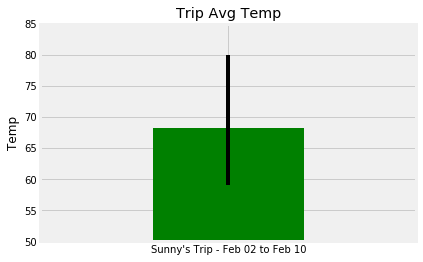

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#borrow calc_temp results to populate chart data
tmin = triptemperature[0][0]
tavg = triptemperature[0][1]
tmax = triptemperature[0][2]

#errorbar
minerror = tavg - tmin
maxerror = tmax - tavg
errorbar = np.array([[minerror], [maxerror]])

#plot
plt.bar("Sunny's Trip - Feb 02 to Feb 10", tavg, yerr=errorbar, color = 'green', alpha = 1)
plt.ylim(50, 85)
plt.xlim(-1, 1)
plt.title('Trip Avg Temp')
plt.ylabel('Temp')

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#define what we want to collect
sel = ([func.sum(Measurement.prcp),Station.station, Station.name, Station.latitude, Station.longitude,Station.elevation])

#run query
otherstations = (session.query(*sel).filter(Station.station == Measurement.station)
                 .filter(Measurement.date >= '2017-02-01').filter(Measurement.date <= '2017-02-10')
                 .group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all())

print(otherstations)       

[(2.3400000000000003, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (1.8, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), (1.79, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), (1.5, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), (0.9400000000000001, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (0.51, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (0.0, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]
